In [1]:
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})

## Загрузка данных

### Пути к файлам

In [3]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### Описание датасета

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


# EDA

## Обработка выбросов, Заполнения NaN

### Целевая переменная

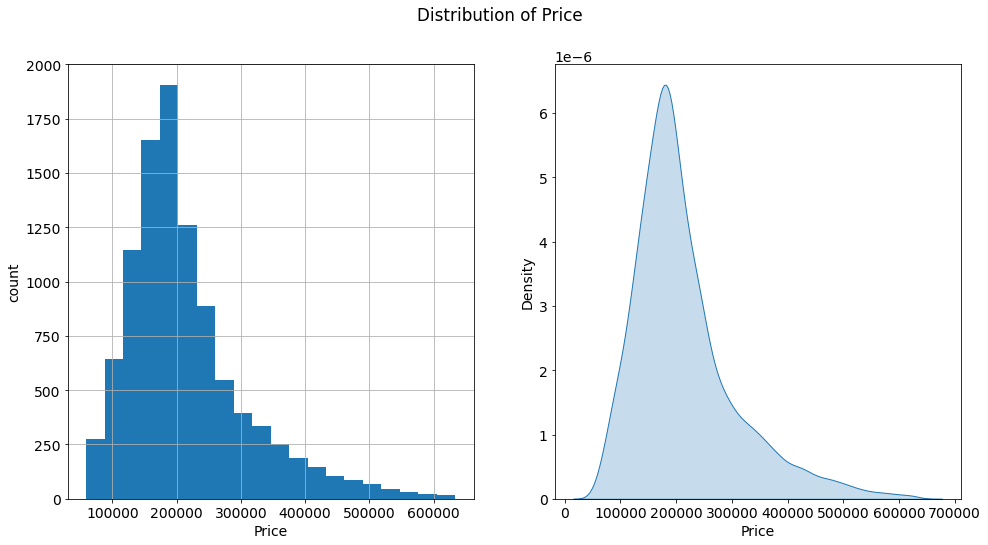

In [5]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [6]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

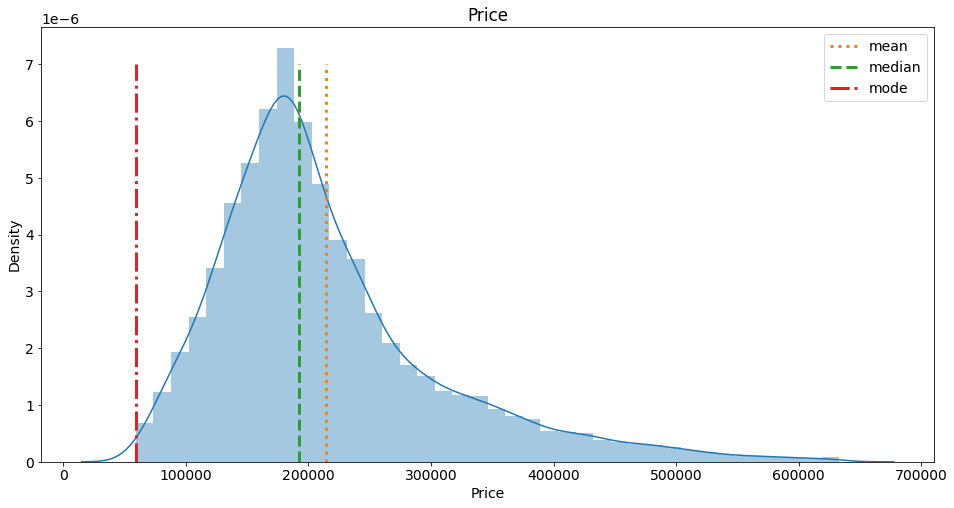

In [7]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=40)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean]*10, y, label='mean', linestyle=':', linewidth=3)
plt.plot([target_median]*10, y, label='median', linestyle='--', linewidth=3)
plt.plot([target_mode]*10, y, label='mode', linestyle='-.', linewidth=3)

plt.title('Price')
plt.legend()
plt.show()

##### В целевой переменной не наблюдается выбросов

### Количественные признаки

In [8]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Проверим на наличие пропусков

In [9]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

##### Rooms

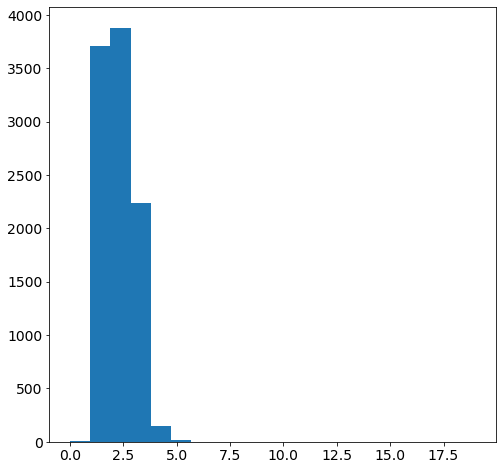

In [10]:
df['Rooms'].hist(figsize=(8,8), bins=20, grid=False);

In [11]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Т.к. количество данных, похожих на выбросы, незначительное, выбросим эти данные из дальнейшего анализа

In [12]:
df = df.loc[(df['Rooms'] > 0) & (df['Rooms'] < 10)]

In [13]:
df['Rooms'].value_counts()

2.0    3880
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

#### Square

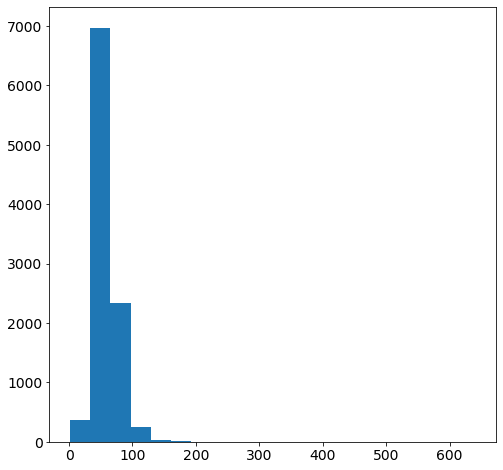

In [14]:
df['Square'].hist(figsize=(8,8), bins=20, grid=False);

Проанализируем объекты, чьи данные похожи на выбросы.

In [15]:
df.loc[(df['Square'] < 10) | (df['Square'] > 200)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
328,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
726,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
1401,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
1776,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
4800,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083
5009,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
7010,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830


Выкинем объекты, площадь которых менее 10кв.м. или более 300кв.м.
Таких объектов не так много и  не жалко потерять эти данные.

In [16]:
df = df.loc[(df['Square'] > 10) & (df['Square'] < 300)]

#### LifeSquare

т.к. имеются пропуски, к обработке выбросов по данному признаку вернемся ниже

#### KitchenSquare

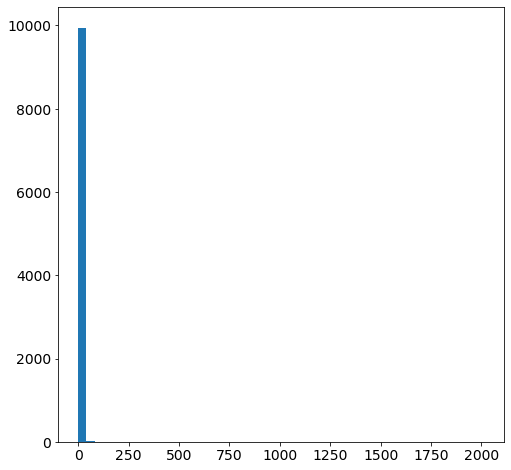

In [17]:
df['KitchenSquare'].hist(figsize=(8,8), bins=50, grid=False);

Будем считать, что в случае данного признака выбросом могут считаться объекты, имеющие площадь менее 0кв.м. или более 20кв.м. и/или превышают общую площадь объекта.
Проанализируем эти объекты.

In [18]:
df.loc[(df['KitchenSquare'] < 0) | ((df['KitchenSquare'] > 20) & (df['KitchenSquare'] > df['Square'])) | 
       (df['KitchenSquare'] > df['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2785,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
5273,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
6505,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275
9520,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207


Удалим данные выбросы

In [19]:
df = df.loc[df['KitchenSquare'] < df['Square']]

#### Floor & HouseFloor

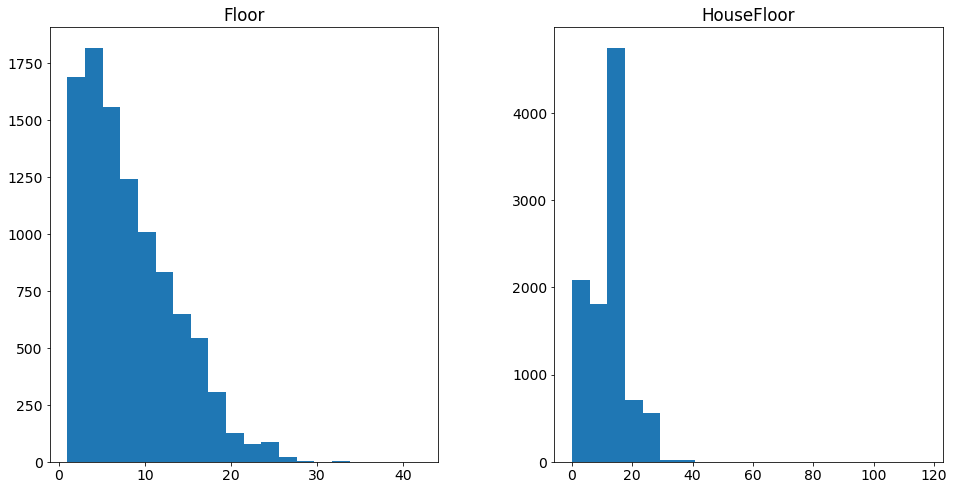

In [20]:
df_floor = df[['Floor', 'HouseFloor']]
df_floor.hist(figsize=(16,8), bins=20, grid=False);

Проверим на аномально маленькие значения

In [21]:
df.loc[(df['Floor'] < 1) | (df['HouseFloor'] < 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
152,12947,53,2.0,56.023342,NaN,0.0,14,0.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,247074.564832
159,13146,74,1.0,46.449711,NaN,0.0,6,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.450148
186,12174,62,1.0,44.954880,NaN,0.0,8,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,133773.301722
229,15661,45,3.0,81.094922,NaN,0.0,15,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,442472.456032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,NaN,0.0,2,0.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,129674.841139
9931,15686,1,1.0,47.402412,NaN,0.0,14,0.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,174740.301224
9940,4711,6,1.0,41.224118,NaN,0.0,8,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,125612.639104
9950,5383,48,3.0,98.994909,NaN,0.0,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446


Заменим данные значения соответствующими медианными значениями

In [22]:
df.loc[df['Floor'] < 1, 'Floor'] = df['Floor'].median()

In [23]:
df.loc[df['HouseFloor'] < 1, 'HouseFloor'] = df['HouseFloor'].median()

Проверим на аномально высокие значения

In [24]:
df.loc[(df['Floor'] > 40) | (df['HouseFloor'] > 40)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
646,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,B,B,43,10621,1,30.0,2,3,B,213171.135199
746,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
765,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.0,3,23,B,117647.461002
1678,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
4657,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515
4987,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.0,1,5,B,411691.504766
5031,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,B,B,50,12238,8,1970.0,2,3,B,179396.521035
5259,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.0,5,5,B,450706.552655


Выкинем объекты, в которых дома имеют более 48 этажей

In [25]:
df = df.loc[df['HouseFloor'] < 49]

Проверим условие, при котором этаж объекта не превышает количество этажей в доме

In [26]:
df.loc[df['Floor'] > df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1130.0,1,5,B,186971.926566
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,NaN,3,2,B,250466.980777
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,366916.246494
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,191205.272608
26,8553,88,3.0,83.262530,4.769174,1.0,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.892020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9953,7659,57,1.0,38.485252,22.550608,8.0,19,17.0,1992,0.133215,B,B,49,11395,3,1406.0,3,4,A,183485.284995
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,248248.935528
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,114878.830713


Приравняем этаж объекта к последнему этажу дома

In [27]:
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor']

#### HouseYear

In [28]:
df['HouseYear'].sort_values()

6794        1910
2066        1912
2795        1912
6250        1914
7610        1916
          ...   
2350        2020
9400        2020
5641        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 9968, dtype: int64

In [29]:
df.loc[df['HouseYear'] > 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8828,11607,147,2.0,44.791836,28.360393,5.0,4.0,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
9163,10814,109,1.0,37.265070,20.239714,9.0,9.0,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396


Удалим выбросы

In [30]:
df = df.loc[df['HouseYear'] < 2022]

#### Ecology_1

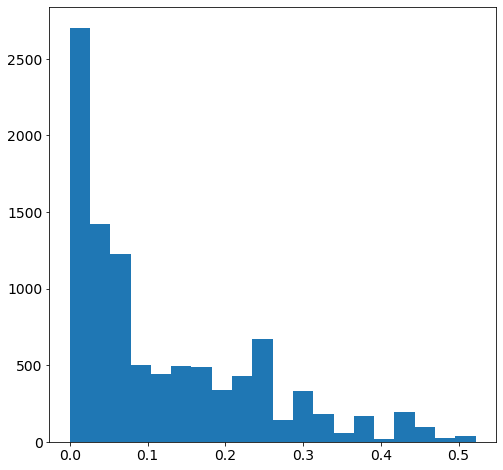

In [31]:
df['Ecology_1'].hist(figsize=(8,8), bins=20, grid=False);

Допустим, что по данному признаку нет выбросов.

#### Social_1, Social_2, Social_3

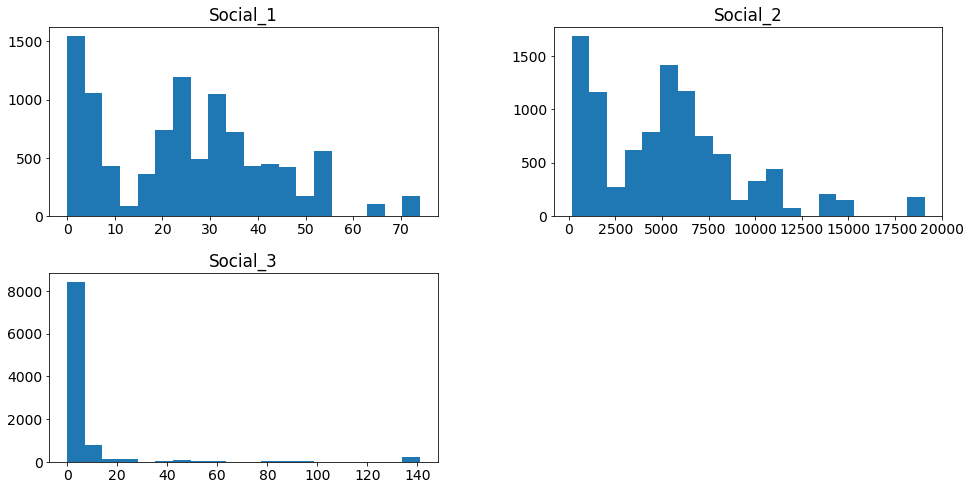

In [32]:
df_social = df[['Social_1', 'Social_2', 'Social_3']]
df_social.hist(figsize=(16,8), bins=20, grid=False);

Рассмотрим признак Social_3

In [33]:
df.loc[df['Social_3'] > 100]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
106,12997,4,3.0,75.128389,52.754246,8.0,9.0,9.0,1956,0.000078,B,B,22,6398,141,1046.0,3,23,B,574631.334051
109,14497,30,3.0,80.820814,NaN,10.0,3.0,3.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,187612.010710
288,6487,30,2.0,75.632556,42.181751,14.0,1.0,1.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,132039.422258
293,14244,30,1.0,40.362080,NaN,1.0,17.0,22.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,126751.451088
330,1855,30,3.0,80.344986,45.809041,10.0,25.0,25.0,1983,0.000078,B,B,22,6398,141,1046.0,3,23,B,384342.688147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9826,11013,43,2.0,58.757047,34.605286,8.0,12.0,17.0,2004,0.000078,B,B,22,6398,141,1046.0,3,23,B,625678.644994
9898,14261,174,3.0,65.812757,48.988726,6.0,5.0,7.0,1935,0.000078,B,B,22,6398,141,1046.0,3,23,B,421851.953639
9899,5408,189,1.0,39.037447,22.031098,8.0,2.0,12.0,1982,0.000078,B,B,22,6398,141,1046.0,3,23,B,192022.684641
9908,9116,30,2.0,64.304289,NaN,1.0,8.0,8.0,2014,0.000078,B,B,22,6398,141,1046.0,3,23,B,189993.189018


Заменим данный признак у вышеуказанных объектов медианным значением

In [34]:
df.loc[df['Social_3'] > 100, 'Social_3'] = df['Social_3'].median()

#### Healthcare_1

Т.к. данный признак почти у половины объектов отсутствует, приведем данный признак из количественного в бинарный

In [35]:
df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'] = 1

In [36]:
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = 0

#### Helthcare_2

In [37]:
df['Helthcare_2'].value_counts()

0    4197
1    2180
3    1663
2    1156
5     386
4     286
6      98
Name: Helthcare_2, dtype: int64

#### Shops_1

In [38]:
df['Shops_1'].value_counts()

0     2307
5     1322
1     1317
2      962
4      839
3      711
6      484
11     400
9      314
7      293
8      252
23     243
10     215
15     175
16      83
19      49
Name: Shops_1, dtype: int64

### Вернемся к признаку LifeSquare

#### Создание вспомогательных признаков

Дополнительно создадим коэффициент для жилой площади по отношению к общей площади без учета площади кухни с целью дальнейшего рассчета жилой площади в местах пропусков

In [39]:
df['k_LifeSquare'] = df['LifeSquare'] / (df['Square'] - df['KitchenSquare'])
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,k_LifeSquare
0,11809,27,3.0,115.027311,NaN,10.0,4.0,10.0,2014,0.075424,...,B,11,3097,0,0.0,0,0,B,305018.871089,NaN
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,B,30,6207,1,1.0,1,0,B,177734.553407,0.727847
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,B,33,5261,0,1.0,3,1,B,282078.720850,0.697548
3,2352,1,1.0,40.409907,NaN,1.0,10.0,22.0,1977,0.007122,...,B,1,264,0,0.0,0,1,B,168106.007630,NaN
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,B,33,8667,2,0.0,0,6,B,343995.102962,0.697521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,...,B,52,10311,6,0.0,1,9,B,119367.455796,0.772153
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,...,B,2,629,1,0.0,0,0,A,199715.148807,0.669679
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,...,B,20,4386,14,0.0,1,5,B,165953.912580,0.671670
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,...,B,47,8004,3,1.0,3,5,B,171842.411855,0.816928


Заменим пропуски в коэффициентах медианой.

In [40]:
median = df['k_LifeSquare'].median()
df['k_LifeSquare'] = df['k_LifeSquare'].fillna(median)

Также медианой заменим явные аномалии.

In [41]:
df.loc[(df['k_LifeSquare'] >= 1) | (df['k_LifeSquare'] <= 0), 'k_LifeSquare'] = median

Посчитаем максимальные и минимальные значения коэффициента и заменим ими значения их превышающие

In [42]:
k_LifeSquare_max = np.quantile(df['k_LifeSquare'], q=0.95)
df.loc[df['k_LifeSquare'] > k_LifeSquare_max, 'k_LifeSquare'] = k_LifeSquare_max
k_LifeSquare_min = np.quantile(df['k_LifeSquare'], q=0.05)
df.loc[df['k_LifeSquare'] < k_LifeSquare_min, 'k_LifeSquare'] = k_LifeSquare_min

#### Замена пропусков

С помощью рассчитанного ранее коэффициента жилой площади заменим пропуски в столбце LifeSquare

In [43]:
df['LifeSquare'] = df['LifeSquare'].fillna((df['Square'] - df['KitchenSquare']) * df['k_LifeSquare'].median())
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,k_LifeSquare
0,11809,27,3.0,115.027311,75.840214,10.0,4.0,10.0,2014,0.075424,...,B,11,3097,0,0.0,0,0,B,305018.871089,0.722100
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,B,30,6207,1,1.0,1,0,B,177734.553407,0.727847
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,B,33,5261,0,1.0,3,1,B,282078.720850,0.697548
3,2352,1,1.0,40.409907,28.457891,1.0,10.0,22.0,1977,0.007122,...,B,1,264,0,0.0,0,1,B,168106.007630,0.722100
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,B,33,8667,2,0.0,0,6,B,343995.102962,0.697521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,...,B,52,10311,6,0.0,1,9,B,119367.455796,0.772153
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,...,B,2,629,1,0.0,0,0,A,199715.148807,0.669679
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,...,B,20,4386,14,0.0,1,5,B,165953.912580,0.671670
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,...,B,47,8004,3,1.0,3,5,B,171842.411855,0.816928


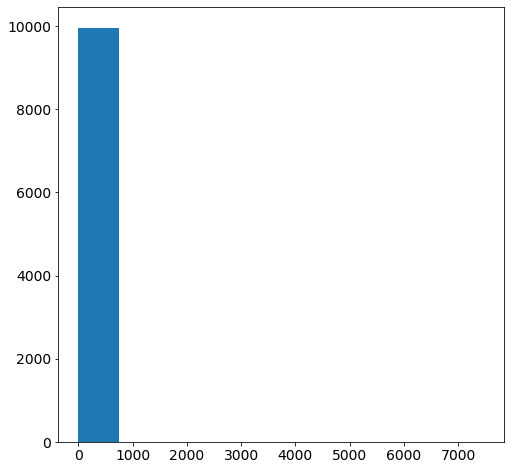

In [44]:
df['LifeSquare'].hist(figsize=(8,8), bins=10, grid=False);

Проанализируем объекты, чьи данные похожи на выбросы.

In [45]:
df.loc[df['LifeSquare'] > 200]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,k_LifeSquare
357,14990,23,2.0,48.449873,263.542020,5.0,5.0,5.0,1972,0.075779,...,B,6,1437,3,0.0,0,2,B,141780.231857,0.722100
1776,16568,27,4.0,200.334539,201.627361,25.0,1.0,2.0,2013,0.041116,...,B,53,14892,4,0.0,1,4,B,528560.506016,0.722100
1906,5548,86,5.0,275.645284,233.949309,26.0,12.0,37.0,2011,0.161976,...,A,31,7010,5,1.0,3,7,B,455264.882666,0.871675
5183,15886,85,3.0,78.059331,461.463614,10.0,12.0,16.0,1998,0.037178,...,B,52,11217,1,1.0,1,7,B,394253.299978,0.722100
8000,16550,27,3.0,81.694417,7480.592129,1.0,9.0,17.0,2016,0.017647,...,B,2,469,0,0.0,0,0,B,217357.492366,0.722100


Выкинем объекты с площадью более 250кв.м.

In [46]:
df = df.loc[df['LifeSquare'] < 250]

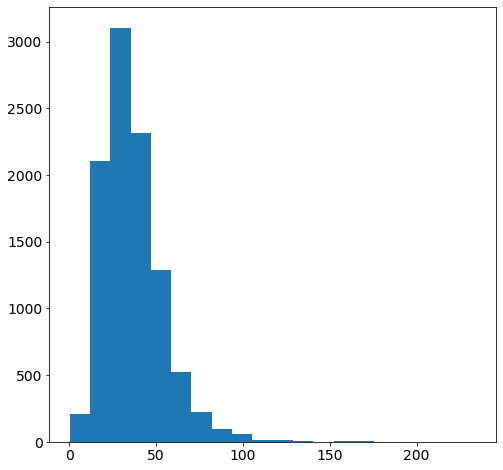

In [47]:
df['LifeSquare'].hist(figsize=(8,8), bins=20, grid=False);

Заменим аномально низкие значения жилой площади  медианными значениями

In [48]:
df.loc[(df['LifeSquare'] < 10), 'LifeSquare'] = df['LifeSquare'].median()

### Бинарные признаки

In [49]:
df['Ecology_2'].value_counts()

B    9866
A      97
Name: Ecology_2, dtype: int64

In [50]:
df['Ecology_3'].value_counts()

B    9688
A     275
Name: Ecology_3, dtype: int64

In [51]:
df['Shops_2'].value_counts()

B    9139
A     824
Name: Shops_2, dtype: int64

In [52]:
binary_to_numbers = {'A': 0, 'B': 1}

df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

## Построение новых фичей

### Средняя площадь объектов, цена объектов и квадратного метра в районе

In [53]:
med_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
    .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,MedPriceByDistrict
0,0,165963.054142
1,1,183809.327114
2,2,208539.501373
3,3,169094.013281
4,4,278639.482329


In [54]:
med_square_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Square':'median'})\
    .rename(columns={'Square':'MedSquareByDistrict'})
med_square_by_district.head()

,DistrictId,MedSquareByDistrict
0,0,48.998792
1,1,60.786490
2,2,47.362676
3,3,47.202193
4,4,53.179791


In [55]:
med_price_m2_by_district = med_price_by_district.merge(med_square_by_district, on=['DistrictId'], how='left')
med_price_m2_by_district.head()

,DistrictId,MedPriceByDistrict,MedSquareByDistrict
0,0,165963.054142,48.998792
1,1,183809.327114,60.786490
2,2,208539.501373,47.362676
3,3,169094.013281,47.202193
4,4,278639.482329,53.179791


In [56]:
med_price_m2_by_district['medPrice_m2'] = med_price_m2_by_district['MedPriceByDistrict'] / med_price_m2_by_district['MedSquareByDistrict']
med_price_m2_by_district.head()

,DistrictId,MedPriceByDistrict,MedSquareByDistrict,medPrice_m2
0,0,165963.054142,48.998792,3387.084585
1,1,183809.327114,60.786490,3023.851625
2,2,208539.501373,47.362676,4403.034587
3,3,169094.013281,47.202193,3582.333846
4,4,278639.482329,53.179791,5239.574588


In [57]:
df = df.merge(med_price_m2_by_district, on=['DistrictId'], how='left')

### Floor_bin

Добавим новый признак, который выделит 2 группы объектов - объекты, расположенные на первом или последнем этаже, и объекты, расположенные на всех остальных этажах.

In [58]:
df['Floor_bin'] = None

In [59]:
df.loc[(df['Floor'] == 1) | (df['Floor'] == df['HouseFloor']), 'Floor_bin'] = 0

In [60]:
df['Floor_bin'] = df['Floor_bin'].fillna(1)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,k_LifeSquare,MedPriceByDistrict,MedSquareByDistrict,medPrice_m2,Floor_bin
0,11809,27,3.0,115.027311,75.840214,10.0,4.0,10.0,2014,0.075424,...,0.0,0,0,1,305018.871089,0.722100,146171.433190,54.797609,2667.478305,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1.0,1,0,1,177734.553407,0.727847,183678.134031,48.013256,3825.571310,1
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1.0,3,1,1,282078.720850,0.697548,183809.327114,60.786490,3023.851625,1
3,2352,1,1.0,40.409907,28.457891,1.0,10.0,22.0,1977,0.007122,...,0.0,0,1,1,168106.007630,0.722100,183809.327114,60.786490,3023.851625,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0.0,0,6,1,343995.102962,0.697521,181706.718894,45.293988,4011.718265,0


### HouseFloor_group

Разделим все дома по их этажности на 4 группы 

In [61]:
df.loc[df['HouseFloor'] < 6, 'HouseFloor_group'] = 1
df.loc[(df['HouseFloor'] > 5) & (df['HouseFloor'] < 13), 'HouseFloor_group'] = 2
df.loc[(df['HouseFloor'] > 12) & (df['HouseFloor'] < 23), 'HouseFloor_group'] = 3
df.loc[df['HouseFloor'] > 22, 'HouseFloor_group'] = 4

### HouseYear_group

Создадим 5 групп домов по их возрасту

In [62]:
df.loc[df['HouseYear'] > 2017, 'HouseYear_group'] = 5
df.loc[(df['HouseYear'] > 2010) & (df['HouseYear'] < 2018), 'HouseYear_group'] = 4
df.loc[(df['HouseYear'] > 2000) & (df['HouseYear'] < 2011), 'HouseYear_group'] = 3
df.loc[(df['HouseYear'] > 1980) & (df['HouseYear'] < 2001), 'HouseYear_group'] = 2
df.loc[df['HouseYear'] < 1981, 'HouseYear_group'] = 1

## Определяем class DataPipeline

In [63]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Новые фичи (features)
        
        # коэффициент для жилой площади по отношению к общей площади без учета площади кухни
        df['k_LifeSquare'] = df['LifeSquare'] / (df['Square'] - df['KitchenSquare'])
        median = df['k_LifeSquare'].median()
        df['k_LifeSquare'] = df['k_LifeSquare'].fillna(median)
        df.loc[(df['k_LifeSquare'] >= 1) | (df['k_LifeSquare'] <= 0), 'k_LifeSquare'] = median
        k_LifeSquare_max = np.quantile(df['k_LifeSquare'], q=0.95)
        df.loc[df['k_LifeSquare'] > k_LifeSquare_max, 'k_LifeSquare'] = k_LifeSquare_max
        k_LifeSquare_min = np.quantile(df['k_LifeSquare'], q=0.05)
        df.loc[df['k_LifeSquare'] < k_LifeSquare_min, 'k_LifeSquare'] = k_LifeSquare_min
        
        # группа объекта, в зависимости от этажа расположения
        df['Floor_bin'] = None
        df.loc[(df['Floor'] == 1) | (df['Floor'] == df['HouseFloor']), 'Floor_bin'] = 0
        df['Floor_bin'] = df['Floor_bin'].fillna(1)
        
        # категория дома, в зависимости от его этажности
        df.loc[df['HouseFloor'] < 6, 'HouseFloor_group'] = 1
        df.loc[(df['HouseFloor'] > 5) & (df['HouseFloor'] < 13), 'HouseFloor_group'] = 2
        df.loc[(df['HouseFloor'] > 12) & (df['HouseFloor'] < 23), 'HouseFloor_group'] = 3
        df.loc[df['HouseFloor'] > 22, 'HouseFloor_group'] = 4

        # категория дома, в зависимости от его возраст
        df.loc[df['HouseYear'] > 2017, 'HouseYear_group'] = 5
        df.loc[(df['HouseYear'] > 2010) & (df['HouseYear'] < 2018), 'HouseYear_group'] = 4
        df.loc[(df['HouseYear'] > 2000) & (df['HouseYear'] < 2011), 'HouseYear_group'] = 3
        df.loc[(df['HouseYear'] > 1980) & (df['HouseYear'] < 2001), 'HouseYear_group'] = 2
        df.loc[df['HouseYear'] < 1981, 'HouseYear_group'] = 1
        
        # 2. Пропуски
        df.loc[df['Healthcare_1'].notnull(), 'Healthcare_1'] = 1
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = 0
        
        df['LifeSquare'] = df['LifeSquare'].fillna((df['Square'] - df['KitchenSquare']) * df['k_LifeSquare'].median())
        df.loc[(df['LifeSquare'] < 10), 'LifeSquare'] = df['LifeSquare'].median()

        # 3. Выбросы (outliers)
        df.loc[df['Floor'] < 1, 'Floor'] = df['Floor'].median()
        df.loc[df['HouseFloor'] < 1, 'HouseFloor'] = df['HouseFloor'].median()
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df['HouseFloor']
        df.loc[df['Social_3'] > 100, 'Social_3'] = df['Social_3'].median()
        
        # 4. Обработка категорий
        binary_to_numbers = {'A': 0, 'B': 1}

        df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)
        
        return df

## Уменьшение объема памяти, который занимает датасет

In [64]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [65]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.13 MB
Memory usage after optimization is: 0.80 MB
Decreased by 62.5%


### Отбор признаков

In [66]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'k_LifeSquare',
 'MedPriceByDistrict',
 'MedSquareByDistrict',
 'medPrice_m2',
 'Floor_bin',
 'HouseFloor_group',
 'HouseYear_group']

In [67]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 
                 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 
                 'Shops_2','k_LifeSquare', 'MedPriceByDistrict', 'MedSquareByDistrict', 'medPrice_m2', 'Floor_bin', 
                 'HouseFloor_group', 'HouseYear_group']

target_name = 'Price'

### Стандартизация признаков

In [68]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16', 'int8', 'int16']).columns.tolist()
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'k_LifeSquare',
 'MedPriceByDistrict',
 'MedSquareByDistrict',
 'medPrice_m2',
 'Floor_bin',
 'HouseFloor_group',
 'HouseYear_group']

In [69]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [70]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [71]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,k_LifeSquare,MedPriceByDistrict,MedSquareByDistrict,medPrice_m2,Floor_bin,HouseFloor_group,HouseYear_group
0,11809,27,1.366760,3.095757,2.294396,0.814184,-0.756648,-0.471251,1.584279,-0.364760,...,-0.881006,0.300272,305018.875000,0.089872,-1.019206,0.248565,-1.163927,0.614359,-0.476810,1.780272
1,3013,22,-1.094742,-0.861935,-0.897816,0.419895,-0.177774,-0.791975,-1.023417,-0.002825,...,-0.881006,0.300272,177734.546875,0.171300,-0.333513,-0.859208,0.008075,0.614359,-0.476810,-0.706435
2,8215,1,1.366760,1.164927,0.587214,0.814184,-1.142565,0.651282,0.171776,-0.782947,...,-0.672768,0.300272,282078.718750,-0.257963,-0.331115,1.226452,-0.803273,0.614359,0.687519,0.122468
3,2352,1,-1.094742,-0.831546,-0.577288,-0.960119,0.401100,1.453091,-0.425820,-0.938142,...,-0.672768,0.300272,168106.000000,0.089872,-0.331115,1.226452,-0.803273,0.614359,0.687519,-0.706435
4,13866,94,0.136009,0.425064,0.035120,0.617040,1.558849,0.490920,-0.697456,1.376121,...,0.368425,0.300272,343995.093750,-0.258339,-0.369555,-1.303221,0.196458,-1.627713,0.687519,-0.706435


###  Разбиение на train и test

In [72]:
X = df[feature_names]
y = df[target_name]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=42)

## Построение модели

### Обучение

#### Gradient Boosting decision trees

Ранее были протестированы модели: LinearRegression (Train R2: 0.686 // Test R2: 0,668), DecisionTreeRegressor (Train R2: 0.788 // Test R2: 0,69), Random Forest (Train R2: 0.79 // Test R2: 0,734).

Лучшей моделью оказалась модель GradientBoostingRegressor.

С помощью GridSearchCV установлено, что для данной модели лучшими параметрами являются:

{'max_depth': 5, 'n_estimators': 200}

In [74]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=200)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=10,
                          n_estimators=200, random_state=42)

### Оценка модели

In [75]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.895
RMSE:	29834.182
MSE:	890078387.998


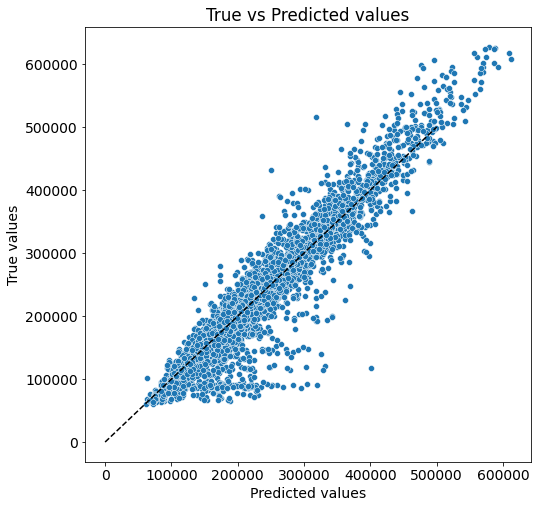

In [76]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.757
RMSE:	46230.661
MSE:	2137274046.985


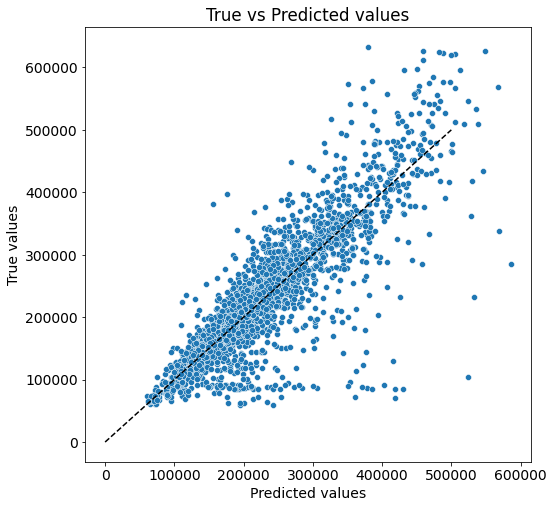

In [77]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Кросс-валидация

In [78]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=4, shuffle=True, random_state=42))
cv_score

array([0.75609848, 0.73219758, 0.71751103, 0.74678414])

In [79]:
cv_score.mean()

0.7381478092519853

### Важность признаков

In [80]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.439914
20,medPrice_m2,0.251528
18,MedPriceByDistrict,0.113940
0,Rooms,0.029605
12,Social_3,0.020182
6,HouseYear,0.019871
2,LifeSquare,0.017866
10,Social_1,0.014311
3,KitchenSquare,0.014164
5,HouseFloor,0.013877


## Прогнозирование на тестовом датасете

In [81]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
submit = pd.read_csv('./sample_submission.csv')

In [82]:
test_df.shape

(5000, 19)

In [83]:
submit.shape

(5000, 2)

In [84]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

#### Проведем обработку пропусков и выбросов тестового датасета

In [85]:
pipe = DataPipeline()
test_df = pipe.transform(test_df)

#### Добавим средние значения цены, площади и квадратного метра по районам, рассчитанные ранее

In [86]:
test_df = test_df.merge(med_price_m2_by_district, on=['DistrictId'], how='left')

#### т.к. в тестовом датасете имеются районы, для которых нет рассчитанных значений, заменим пропуски медианными значениями

In [87]:
test_df['MedPriceByDistrict'] = test_df['MedPriceByDistrict'].fillna(median)
test_df['MedSquareByDistrict'] = test_df['MedSquareByDistrict'].fillna(median)
test_df['medPrice_m2'] = test_df['medPrice_m2'].fillna(median)

#### Проведем стандартизацию и оставим необходимые нам признаки

In [88]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(test_df[feature_names_for_stand])

In [89]:
test_df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [90]:
test_df = test_df[feature_names]
test_df.head(3)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Helthcare_2,Shops_1,Shops_2,k_LifeSquare,MedPriceByDistrict,MedSquareByDistrict,medPrice_m2,Floor_bin,HouseFloor_group,HouseYear_group
0,-1.085258,-1.026766,-1.158971,-0.098180,-0.571516,-0.605352,-0.774992,-0.697594,0.098453,0.175258,...,-0.215841,-0.678852,0.299666,-1.729353,0.119197,-0.960192,0.616674,0.372067,-0.394315,-0.692062
1,-1.085258,-0.731008,0.263153,0.404381,-0.196284,0.631512,1.755796,-0.397445,0.098453,0.175258,...,-0.891612,-0.888194,-3.337053,0.141723,-0.740785,0.556013,-0.973255,0.372067,0.731657,1.821481
2,0.107333,0.157886,-0.096719,0.303869,2.055109,0.940728,-0.398066,0.762360,0.098453,0.175258,...,-0.891612,-0.678852,0.299666,0.141723,-1.043271,0.260014,-1.171058,-2.687691,0.731657,-0.692062


#### На подготовленном тестовом датасете сделаем прогноз цены объектов и сохраним в файл 'gb_submit.csv'

In [91]:
predictions = gb_model.predict(test_df)
predictions

array([170970.12214176, 126814.41174103, 144879.76055796, ...,
       150026.81794585, 196248.41985252, 265372.28901409])

In [92]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,170970.122142
1,5925,126814.411741
2,960,144879.760558
3,3848,126536.400693
4,746,188098.964565


In [93]:
submit.to_csv('gb_submit.csv', index=False)